In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import torch


In [2]:
def draw_diagram(fn, gen_dots=False, draw_axes=True):
    img = Image.new(mode='RGB', size=(4000, 4000), color='white')
    draw = ImageDraw.Draw(img)
    if draw_axes:
        draw.line([(2000, 250), (2000, 3750)], fill='gray', width=20)
        draw.line([(250, 2000), (3750, 2000)], fill='gray', width=20)
        [
            draw.line(((x, 1950), (x, 2050)), fill='gray', width=20)
            for x in range(500, 3700, 300)
        ]
        [
            draw.line(((1950, y), (2050, y)), fill='gray', width=20)
            for y in range(500, 3700, 300)
        ]
        font = ImageFont.truetype('arial.ttf', 100)
        [
            draw.text(
                (-80 + 2000 + 300 * x, 2050), str(x / 10), fill='black', font=font
            )
            for x in range(-5, 6)
            if x != 0
        ]
        [
            draw.text(
                (1760, -50 + 2000 + 300 * y), str(-y / 10), fill='black', font=font
            )
            for y in range(-5, 6)
            if y != 0
        ]
        draw.text((3750, 2050), 'x', fill='black', font=font)
        draw.text((1900, 180), 'y', fill='black', font=font)
    draw.ellipse([(500, 500), (3500, 3500)], outline='green', width=20)
    draw.rectangle([(500, 500), (3500, 3500)], outline='blue', width=20)
    if gen_dots:
        for i in range(400):
            xy = np.round(np.random.rand(1, 2).squeeze() * 3000 + 500).astype(int)
            corners = []
            corners.append(tuple((xy - 10).tolist()))
            corners.append(tuple((xy + 10).tolist()))
            draw.ellipse(corners, fill='red', outline='red')
    img = img.resize((600, 600), resample=PIL.Image.LANCZOS)
    with open(fn, 'wb') as f:
        img.save(f)
    return img


A circle inscribed in a square of size 1, centered in the origin. This is the 2-dimensional case.

It can be generalized to 3D (sphere, cube) and beyond (N-sphere, N-cube).

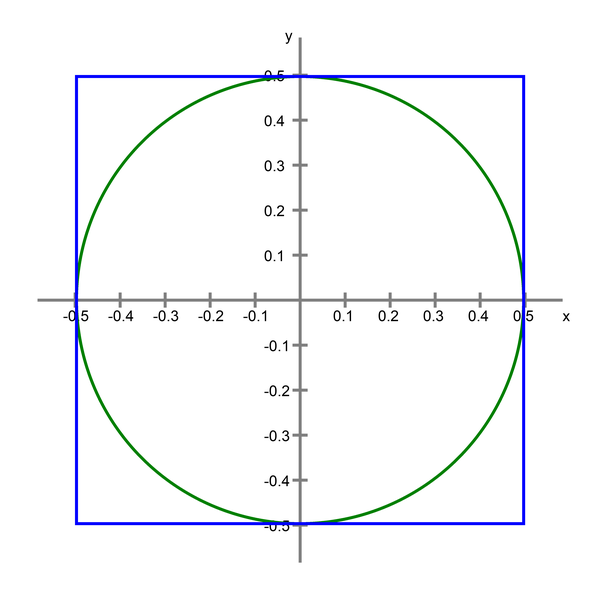

In [3]:
draw_diagram('diagram_clear.png', gen_dots=False, draw_axes=True)


Generating points at random. Some points will be inside the circle / sphere / N-sphere.

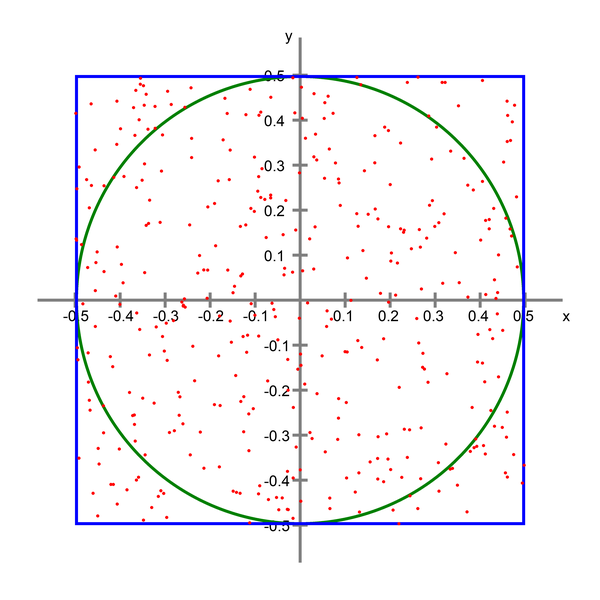

In [4]:
draw_diagram('diagram_dots.png', gen_dots=True)


Generate a large number of random points. Count the points that fall within the N-sphere. Divide that count by the total number of points.

The result is an approximation for the volume of the N-sphere divided by the volume of the N-cube. The volume of the N-cube is always 1, so the ratio is equal to the volume of the sphere.

TLDR: We approximate the volume of the sphere.

The more total points are generated, the better the approximation.

This is a basic application of the Monte Carlo method.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# force CPU
# device = 'cpu'

# reduce d_max if too many ratio values are 0.0
d_max = 22
# reduce n if you run out of memory
n = 10**8

ratio = np.zeros(d_max)

for d in tqdm(range(d_max, 0, -1)):
    torch.manual_seed(0)
    # combine large tensor statements for better memory allocation
    ratio[d - 1] = (
        torch.sum(
            torch.sqrt(
                torch.sum(torch.pow(torch.rand((n, d), device=device) - 0.5, 2), dim=1)
            )
            <= 0.5
        ).item()
        / n
    )

# clean up memory
torch.cuda.empty_cache()


100%|██████████| 22/22 [00:01<00:00, 11.13it/s]


In [6]:
print(list(ratio))


[1.0, 0.78548005, 0.52364381, 0.30841056, 0.16450286, 0.08075666, 0.03688062, 0.015852, 0.00645304, 0.00249584, 0.00092725, 0.00032921, 0.00011305, 3.766e-05, 1.14e-05, 3.29e-06, 9.9e-07, 2.8e-07, 8e-08, 3e-08, 2e-08, 0.0]


In [7]:
sns.set_style(style='whitegrid')


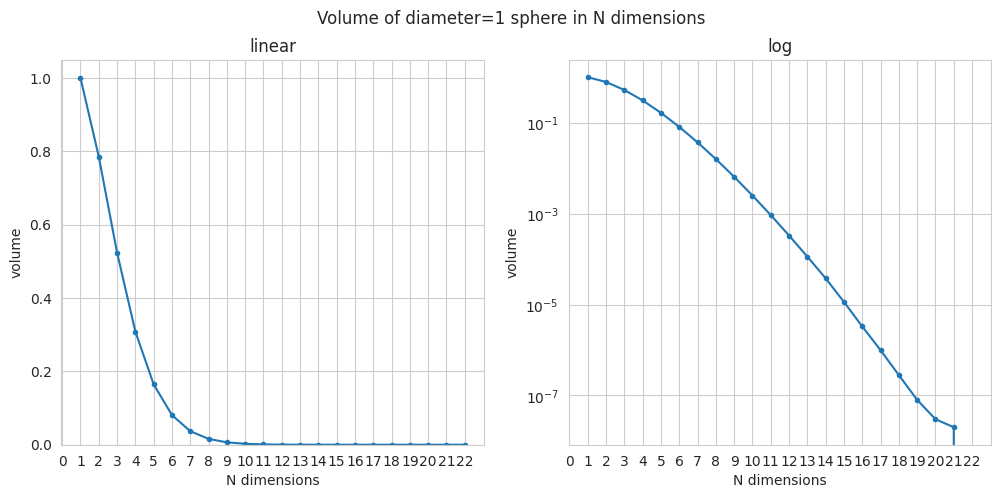

In [8]:
r_df = pd.DataFrame(data={'N': np.arange(1, d_max + 1), 'ratio': ratio})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

r_df.plot(
    ax=ax1,
    x='N',
    y='ratio',
    style='.-',
    logy=False,
    legend=False,
    title='linear',
)
ax1.set_xticks(np.arange(0, d_max + 1))
ax1.set_xlabel("N dimensions")
ax1.set_ylabel("volume")
_ = ax1.set_ylim(bottom=0.0)

r_df.plot(
    ax=ax2,
    x='N',
    y='ratio',
    style='.-',
    logy=True,
    legend=False,
    title='log',
)
ax2.set_xticks(np.arange(0, d_max + 1))
ax2.set_xlabel("N dimensions")
ax2.set_ylabel("volume")
# _ = ax2.set_ylim(bottom=0.0)

fig.suptitle(f'Volume of diameter=1 sphere in N dimensions')
fig.savefig("volume.png")


Calculate the length of the diagonal of the cube in N dimensions.

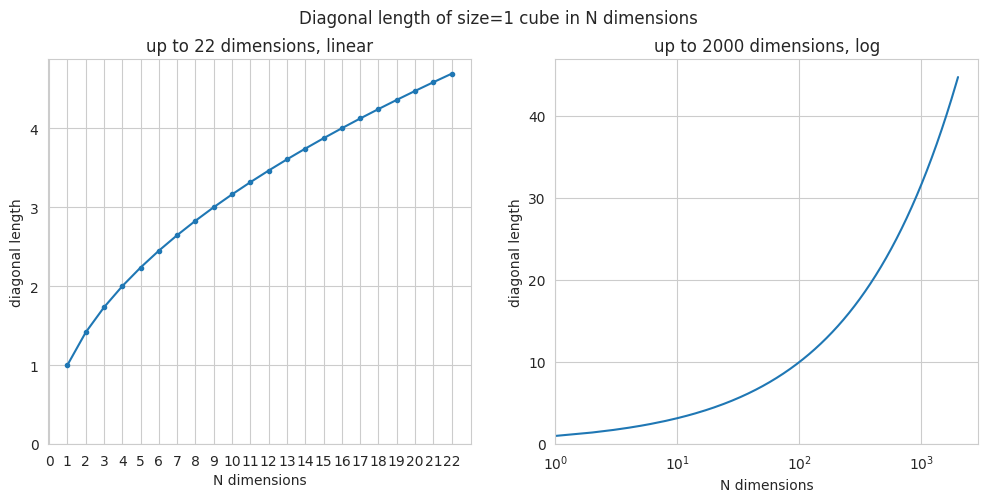

In [9]:
# r_df = pd.DataFrame(data={'N': np.arange(1, d_max + 1), 'diag': diagonal})
d_max_diag = 2000
dims = np.arange(1, d_max_diag + 1)
diag_len = np.sqrt(dims)
r_df = pd.DataFrame({'N': dims, "diag": diag_len})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
r_df.iloc[:d_max, :].plot(
    ax=ax1,
    x='N',
    y='diag',
    style='.-',
    legend=False,
    title=f'up to {d_max} dimensions, linear',
)
ax1.set_xticks(np.arange(0, d_max + 1))
ax1.set_xlabel("N dimensions")
ax1.set_ylabel("diagonal length")
_ = ax1.set_ylim(bottom=0.0)

r_df.plot(
    ax=ax2,
    x='N',
    y='diag',
    logx=True,
    legend=False,
    title=f'up to {d_max_diag} dimensions, log',
)
ax2.set_xlabel("N dimensions")
ax2.set_ylabel("diagonal length")
_ = ax2.set_ylim(bottom=0.0)
_ = ax2.set_xlim(left=1.0)

fig.suptitle('Diagonal length of size=1 cube in N dimensions')
fig.savefig("diagonal.png")


Calculate the average distance between any 2 random points within the cube in N dimensions.

In [10]:
n_points_d = 10**3
# how many pairs of points are there
dist_count = n_points_d * (n_points_d - 1) / 2
# we use the full pair-wise matrix of distances,
# so each distance will be counted twice
dist_count = 2 * dist_count
d_max = d_max_diag

avg_dist = np.zeros(d_max)
avg_dist_nn = np.zeros(d_max)

for d in tqdm(range(d_max, 0, -1)):
    torch.manual_seed(0)
    # generate random points
    point_coordinates = torch.rand((n_points_d, d), device=device)
    # compute differences of point coordinates on all axes
    coord_diffs = point_coordinates.unsqueeze(1) - point_coordinates
    del point_coordinates
    # square the coordinate differences
    diffs_squared = torch.pow(coord_diffs, 2)
    del coord_diffs
    # compute distances between any 2 points
    distances_full = torch.sqrt(torch.sum(diffs_squared, dim=2))
    del diffs_squared
    # compute average distance between points
    avg_dist[d - 1] = torch.sum(distances_full).item() / dist_count
    # compute distances to nearest neighbors
    distances_full[distances_full == 0.0] = np.sqrt(d) + 1
    distances_nn, _ = torch.min(distances_full, dim=0)
    del distances_full
    # compute average distance to nearest neighbors
    avg_dist_nn[d - 1] = torch.mean(distances_nn).item()
    del distances_nn

torch.cuda.empty_cache()


100%|██████████| 2000/2000 [00:46<00:00, 43.35it/s] 


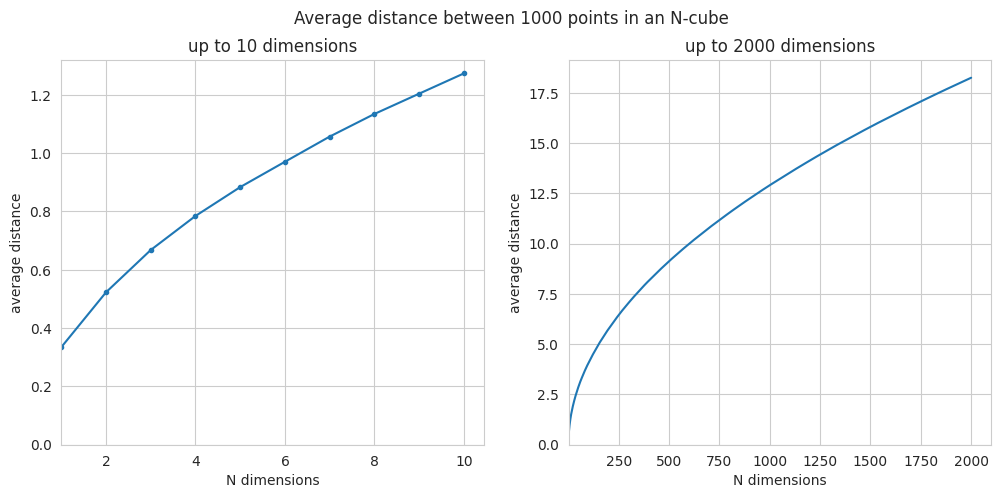

In [11]:
r_df = pd.DataFrame(data={'N': np.arange(1, d_max + 1), 'avg_dist': avg_dist})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

n_low = 10
r_df.iloc[:n_low, :].plot(
    ax=ax1,
    x='N',
    y='avg_dist',
    style='.-',
    logy=False,
    legend=False,
    title=f'up to {n_low} dimensions',
)
# ax.set_xticks(np.arange(0, d_max + 1))
ax1.set_xlabel("N dimensions")
ax1.set_ylabel("average distance")
_ = ax1.set_ylim(bottom=0.0)
_ = ax1.set_xlim(left=1)

r_df.plot(
    ax=ax2,
    x='N',
    y='avg_dist',
    # style='.-',
    logy=False,
    legend=False,
    title=f'up to {d_max} dimensions',
)
# ax.set_xticks(np.arange(0, d_max + 1))
ax2.set_xlabel("N dimensions")
ax2.set_ylabel("average distance")
_ = ax2.set_ylim(bottom=0.0)
_ = ax2.set_xlim(left=1)

fig.suptitle(f'Average distance between {n_points_d} points in an N-cube')
fig.savefig("average_distance.png")


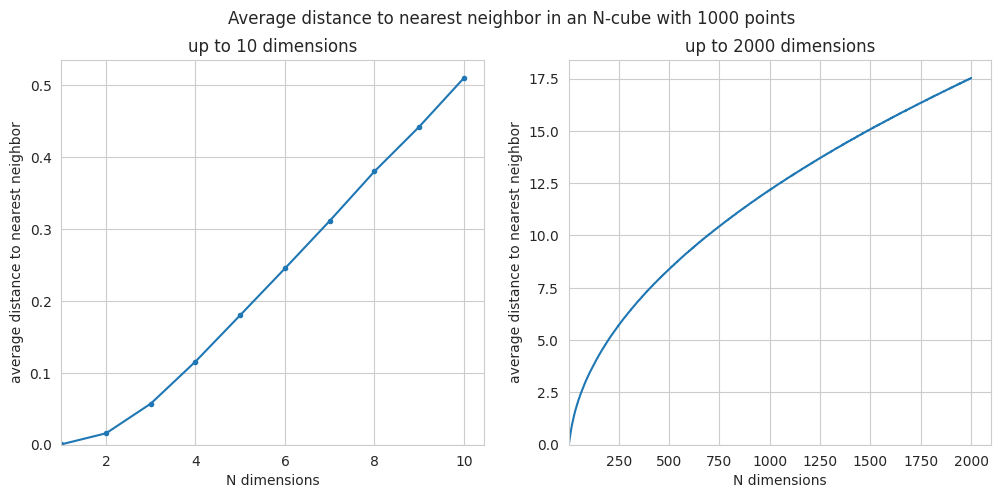

In [12]:
r_df = pd.DataFrame(data={'N': np.arange(1, d_max + 1), 'avg_dist': avg_dist_nn})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

n_low = 10
r_df.iloc[:n_low, :].plot(
    ax=ax1,
    x='N',
    y='avg_dist',
    style='.-',
    logy=False,
    legend=False,
    title=f'up to {n_low} dimensions',
)
# ax.set_xticks(np.arange(0, d_max + 1))
ax1.set_xlabel("N dimensions")
ax1.set_ylabel("average distance to nearest neighbor")
_ = ax1.set_ylim(bottom=0.0)
_ = ax1.set_xlim(left=1)

r_df.plot(
    ax=ax2,
    x='N',
    y='avg_dist',
    # style='.-',
    logy=False,
    legend=False,
    title=f'up to {d_max} dimensions',
)
# ax.set_xticks(np.arange(0, d_max + 1))
ax2.set_xlabel("N dimensions")
ax2.set_ylabel("average distance to nearest neighbor")
_ = ax2.set_ylim(bottom=0.0)
_ = ax2.set_xlim(left=1)

fig.suptitle(
    f'Average distance to nearest neighbor in an N-cube with {n_points_d} points'
)
fig.savefig("average_distance_nn.png")
